In [83]:
import numpy as np
import pandas as pd
import torch
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns 
from itertools import combinations

plt.rcParams.update({
    'figure.dpi' : 150
})


/home/henk/miniconda3/envs/wt-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [84]:
test_survived = pd.read_csv('gender_submission.csv')
test_set = pd.read_csv('test.csv').merge(test_survived, on='PassengerId')
train_set = pd.read_csv('train.csv')
dfs = [train_set, test_set]

remapper = {
    'Survived' : {
        0 : 'Died',
        1 : 'Survived'
    },
    'Embarked' : {
         'C' : 'Cherbourg', 
         'Q' : 'Queenstown',
         'S' : 'Southampton'
    },
    'Pclass' : {
        1 : 'First class',
        2 : 'Second class',
        3 : 'Third class'
    }
}
[df.replace(remapper, inplace= True) for df in dfs]

total_set = pd.concat(dfs)

dfs = {i : eval(i).reset_index() for i in ['train_set', 'test_set', 'total_set']}
total_df = pd.concat(dfs, axis =0).drop(columns='index')

# Meaning of columns:

| Column Name | Meaning | Values |
|---|---|---|
| Survived | If survived | 0 = No, 1 = Yes |
| Pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| Sex | sex | Male / Female |
| Age | Age in years | xx.5 = guess, 0.?? months (float) |
| Sibsp | Number of siblings / spouses aboard | int |
| Parch | Number of parents / children aboard | int | 
| Ticket | Ticket number | string |
| Fare | Passenger fare | float |
| Cabin | Cabin number | string |
| Embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

# (Small) Categorical columns

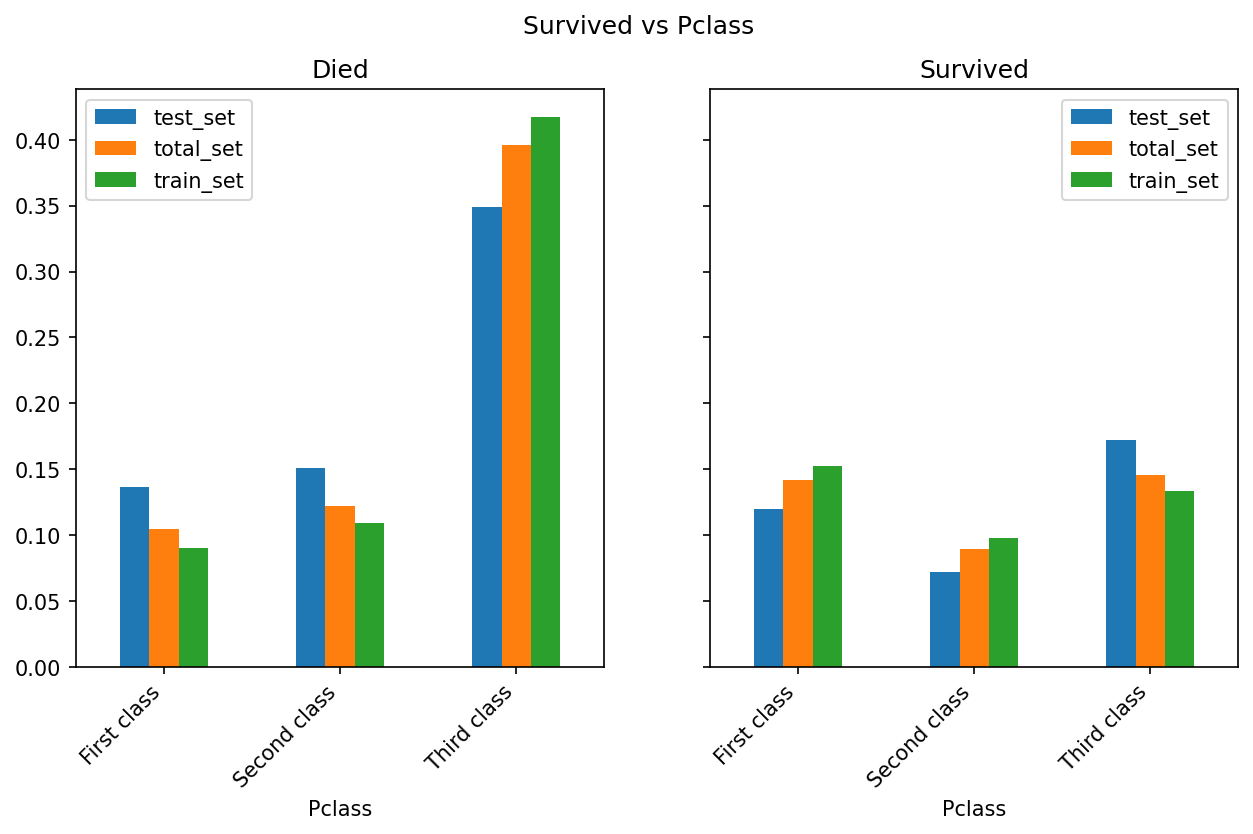

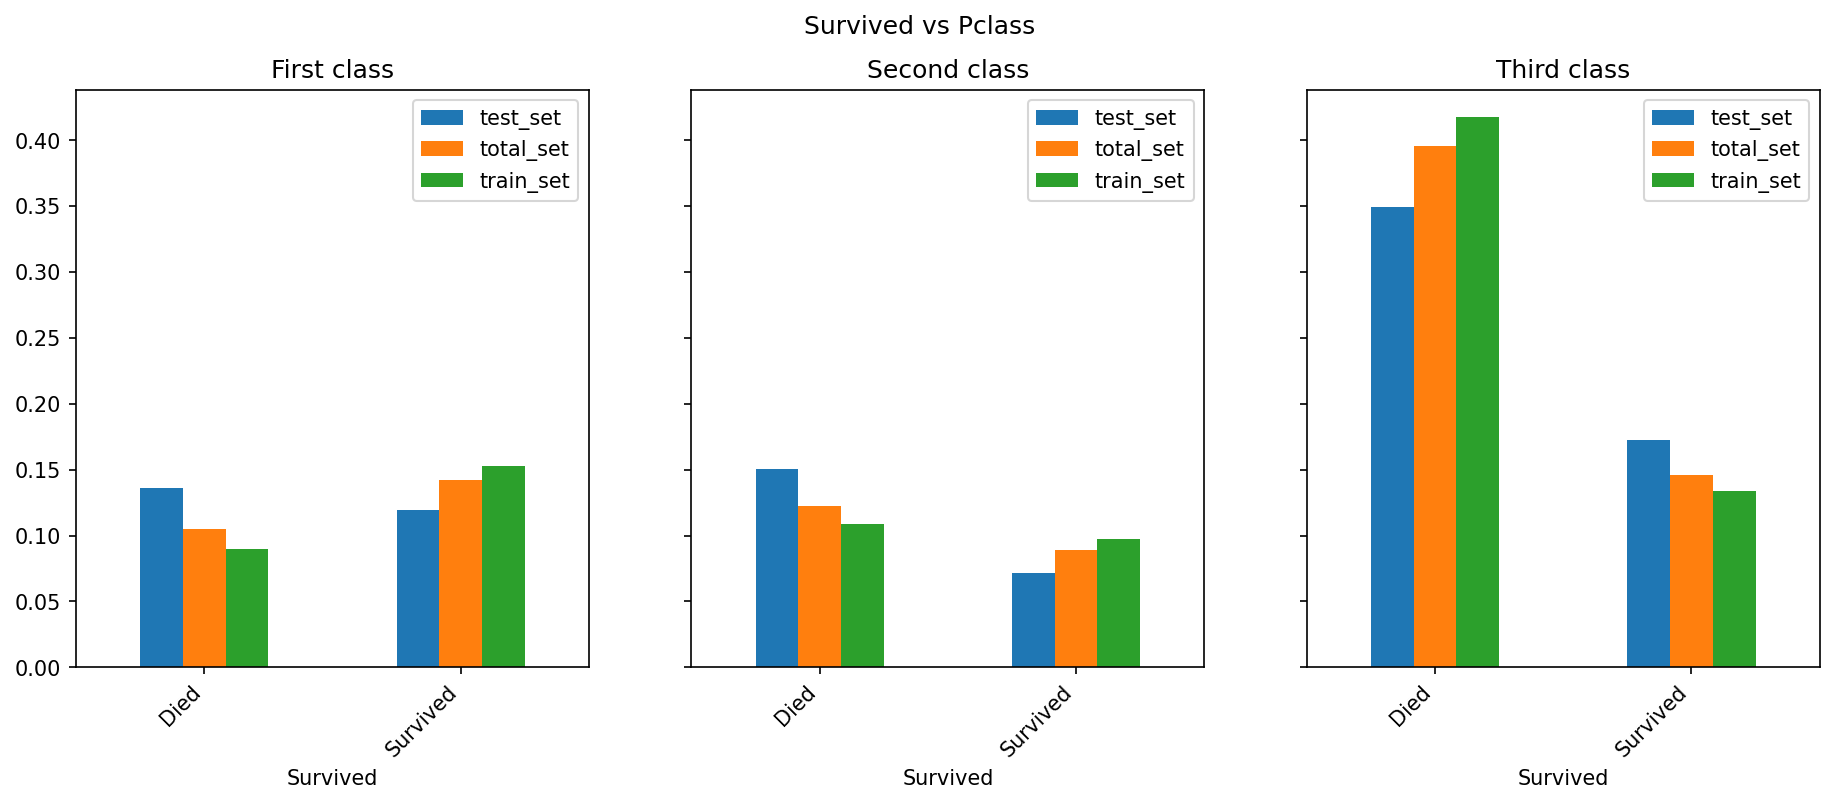

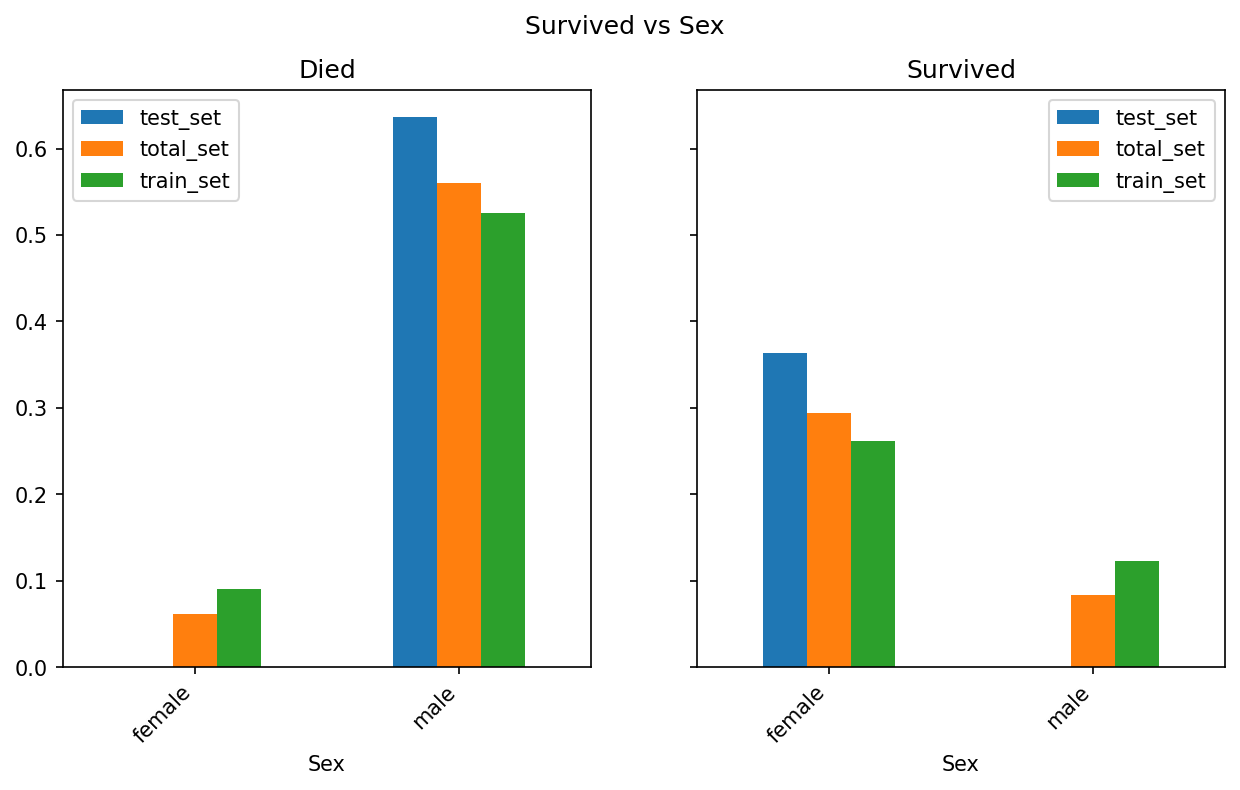

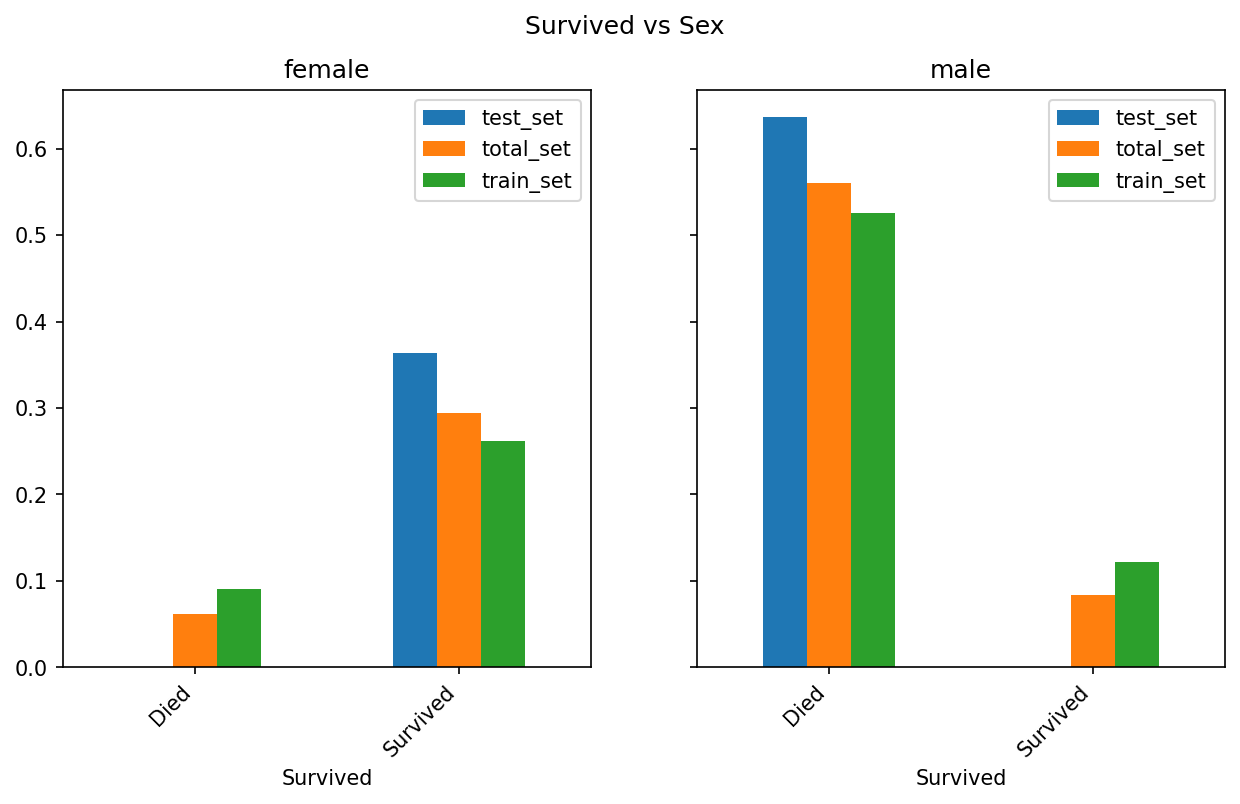

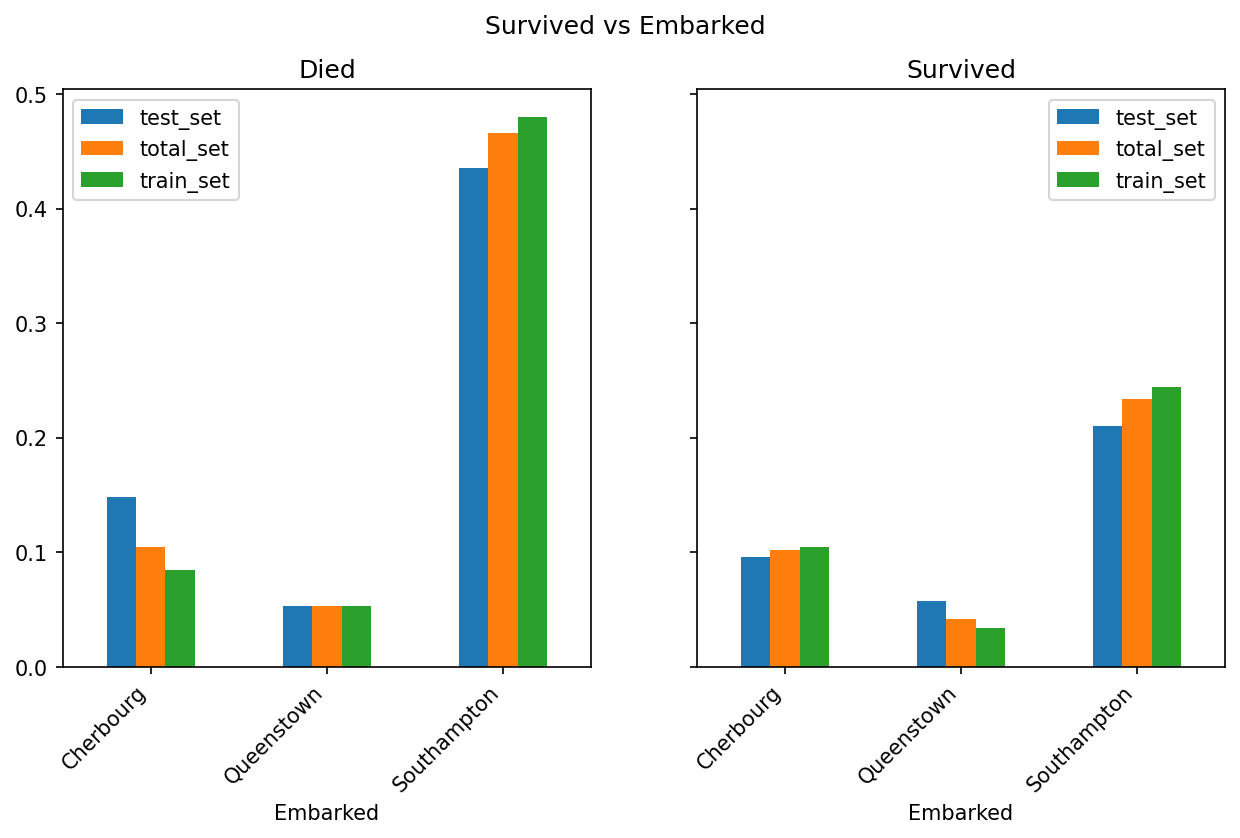

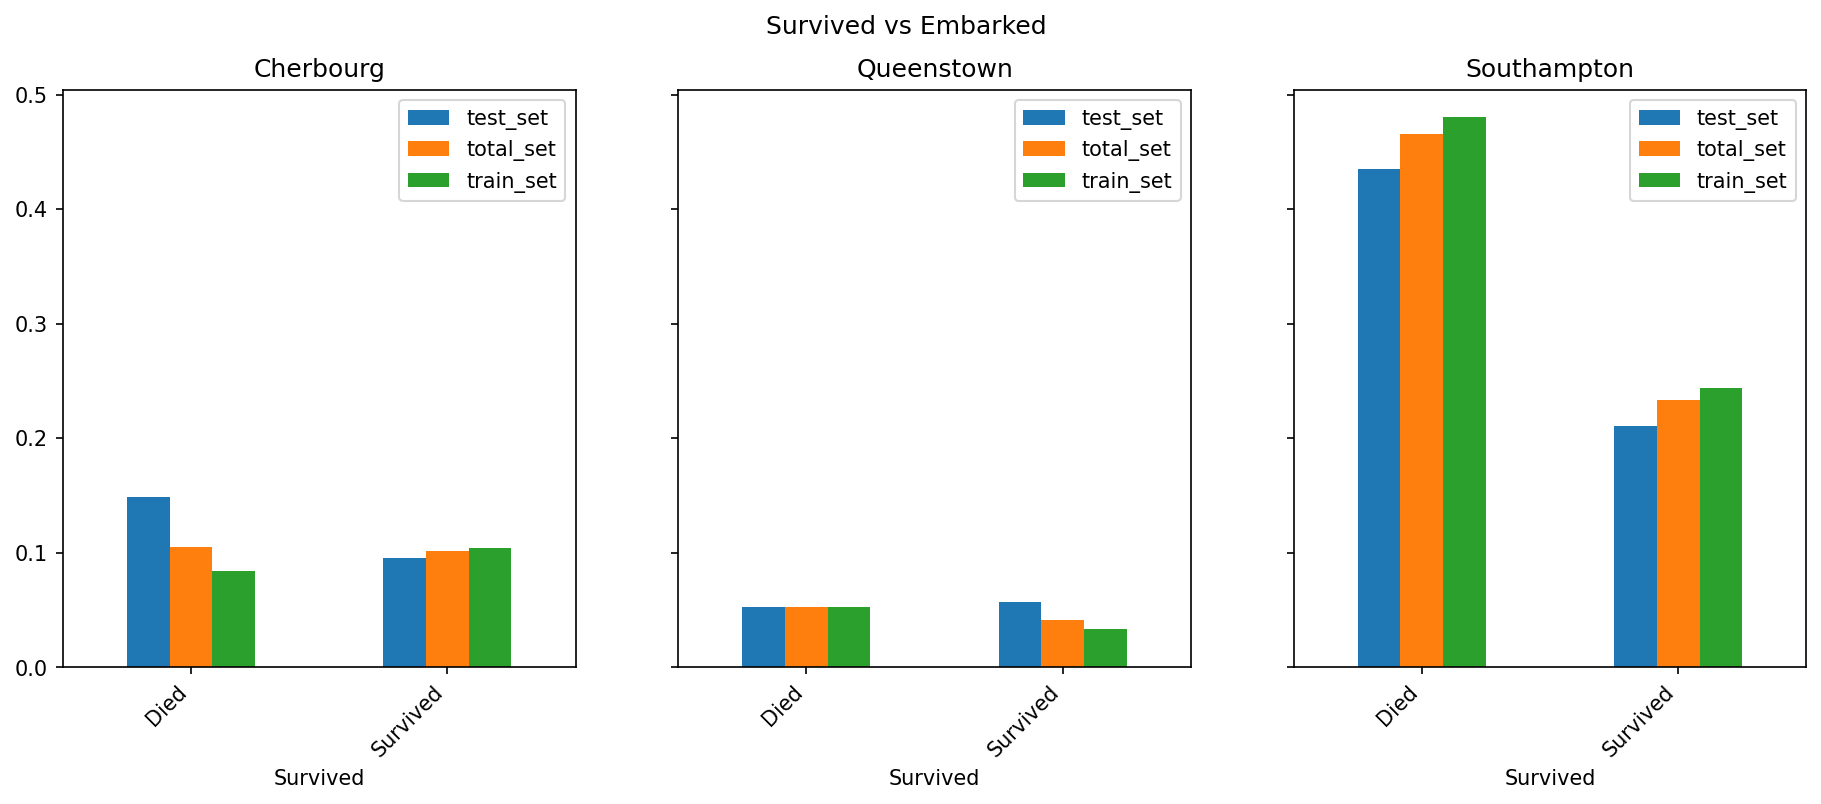

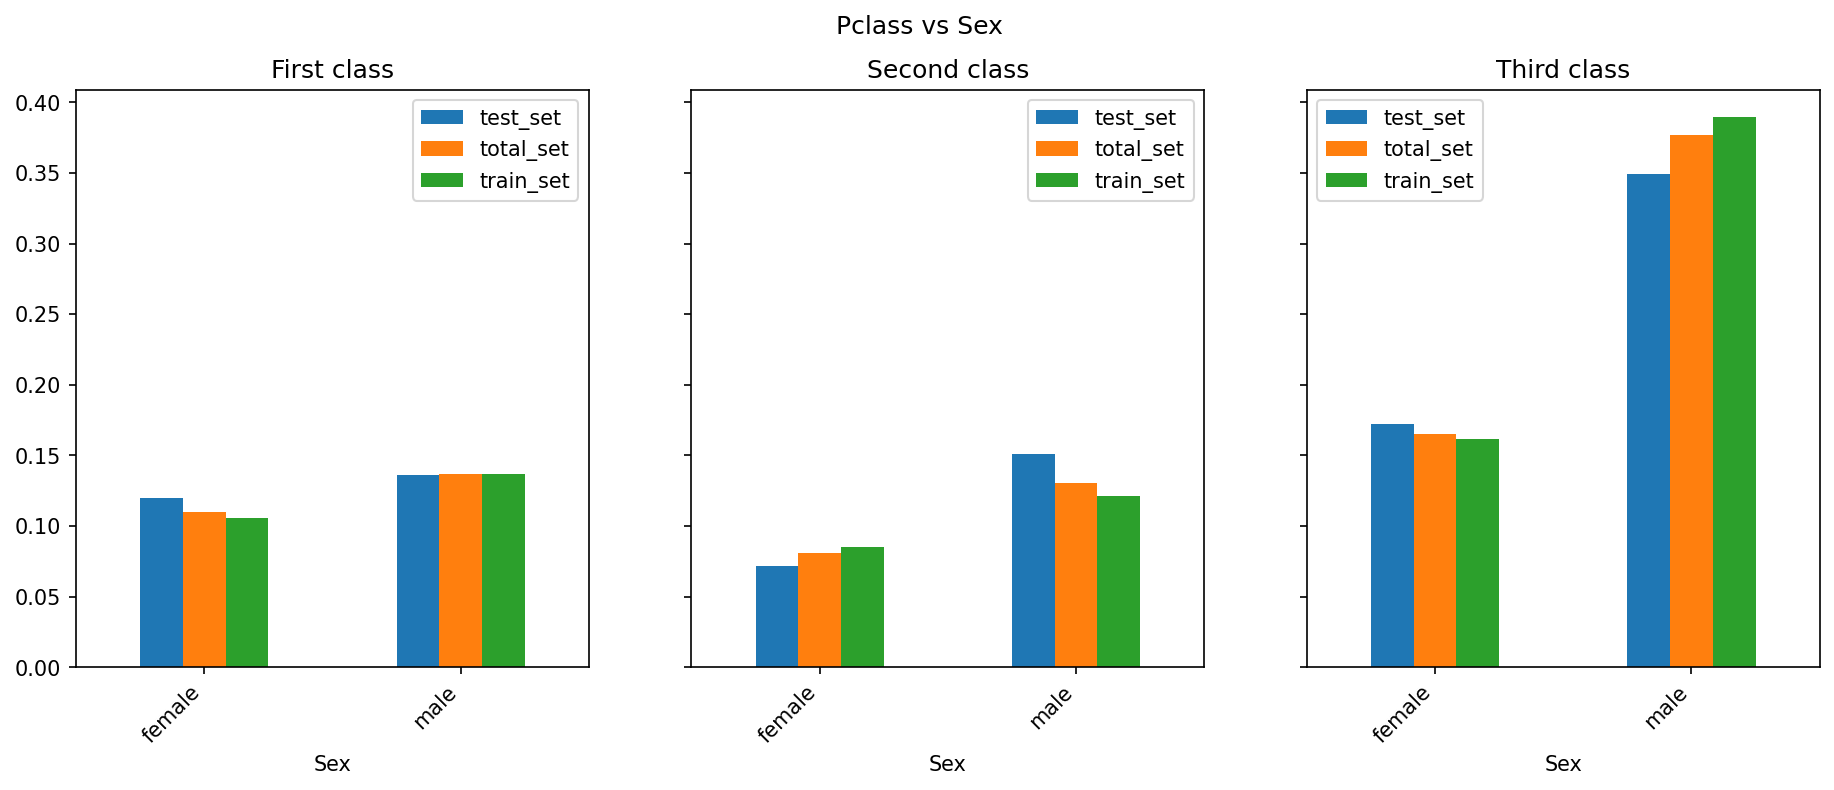

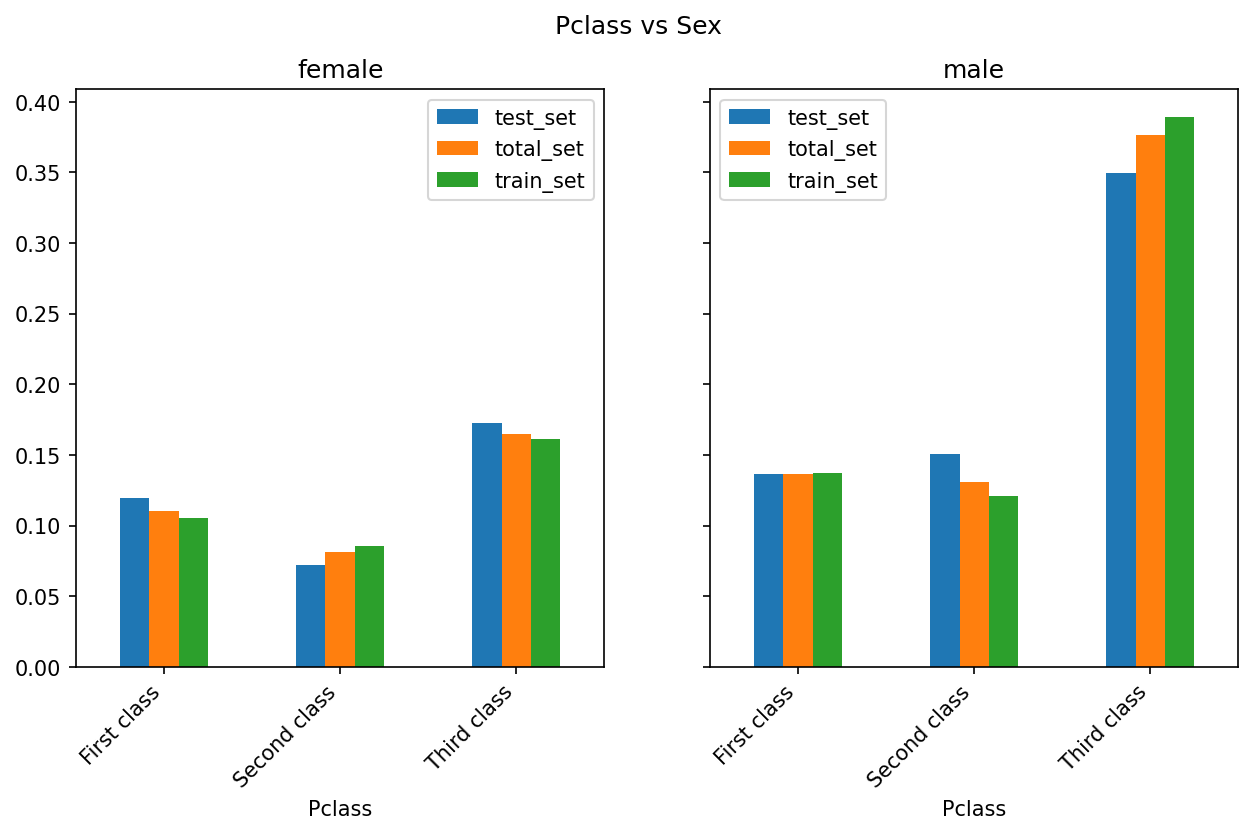

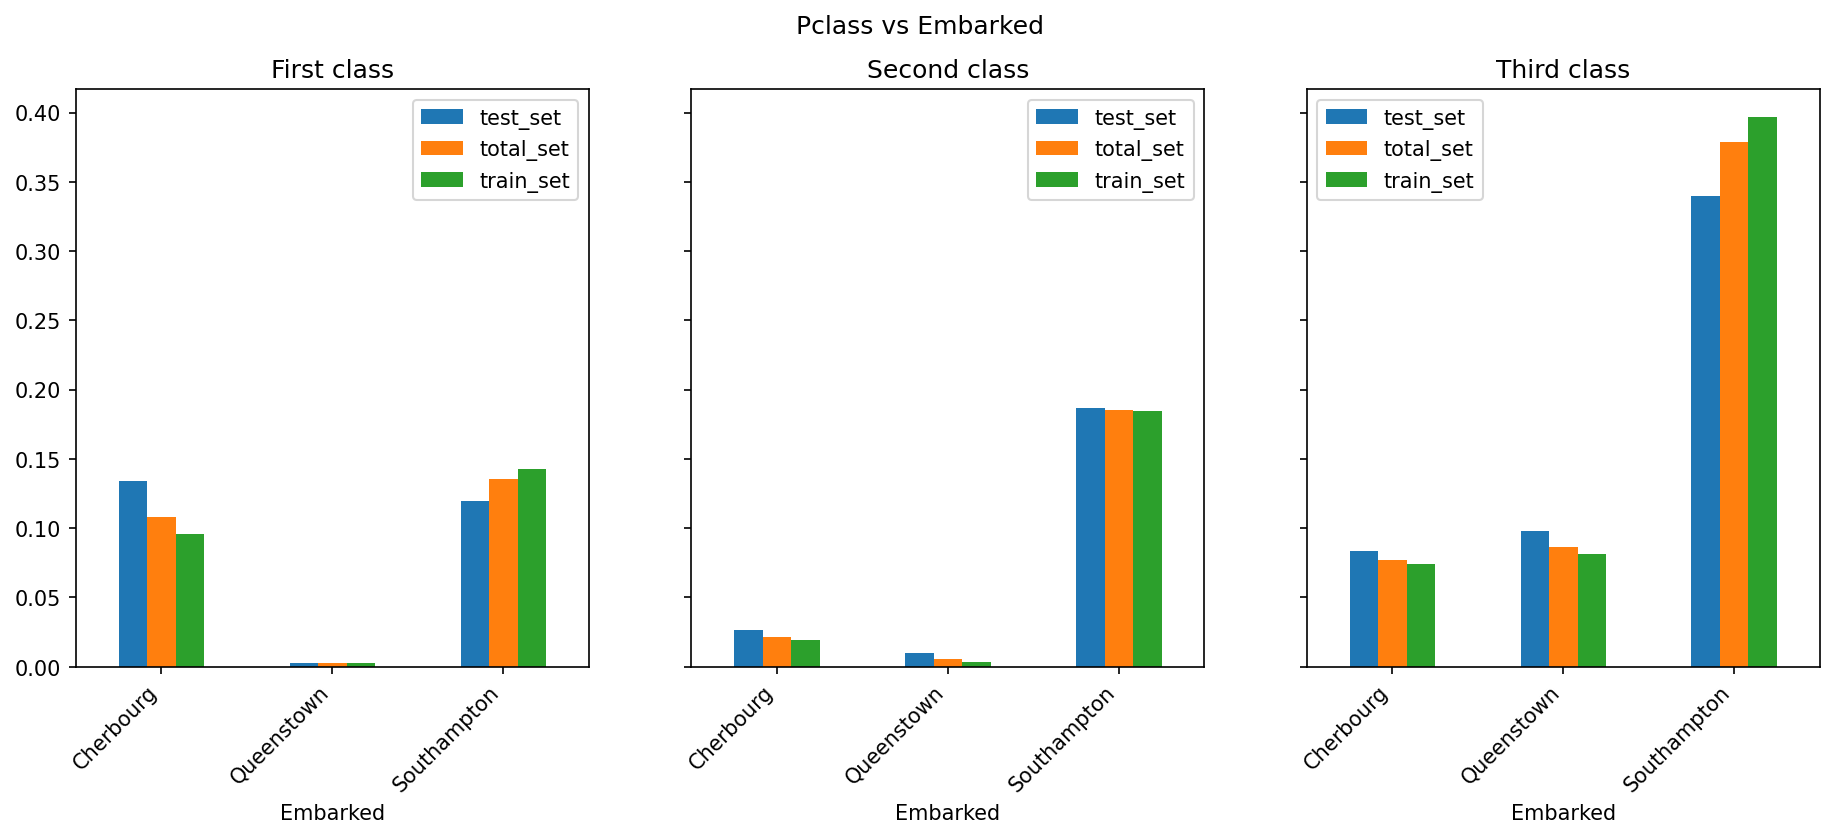

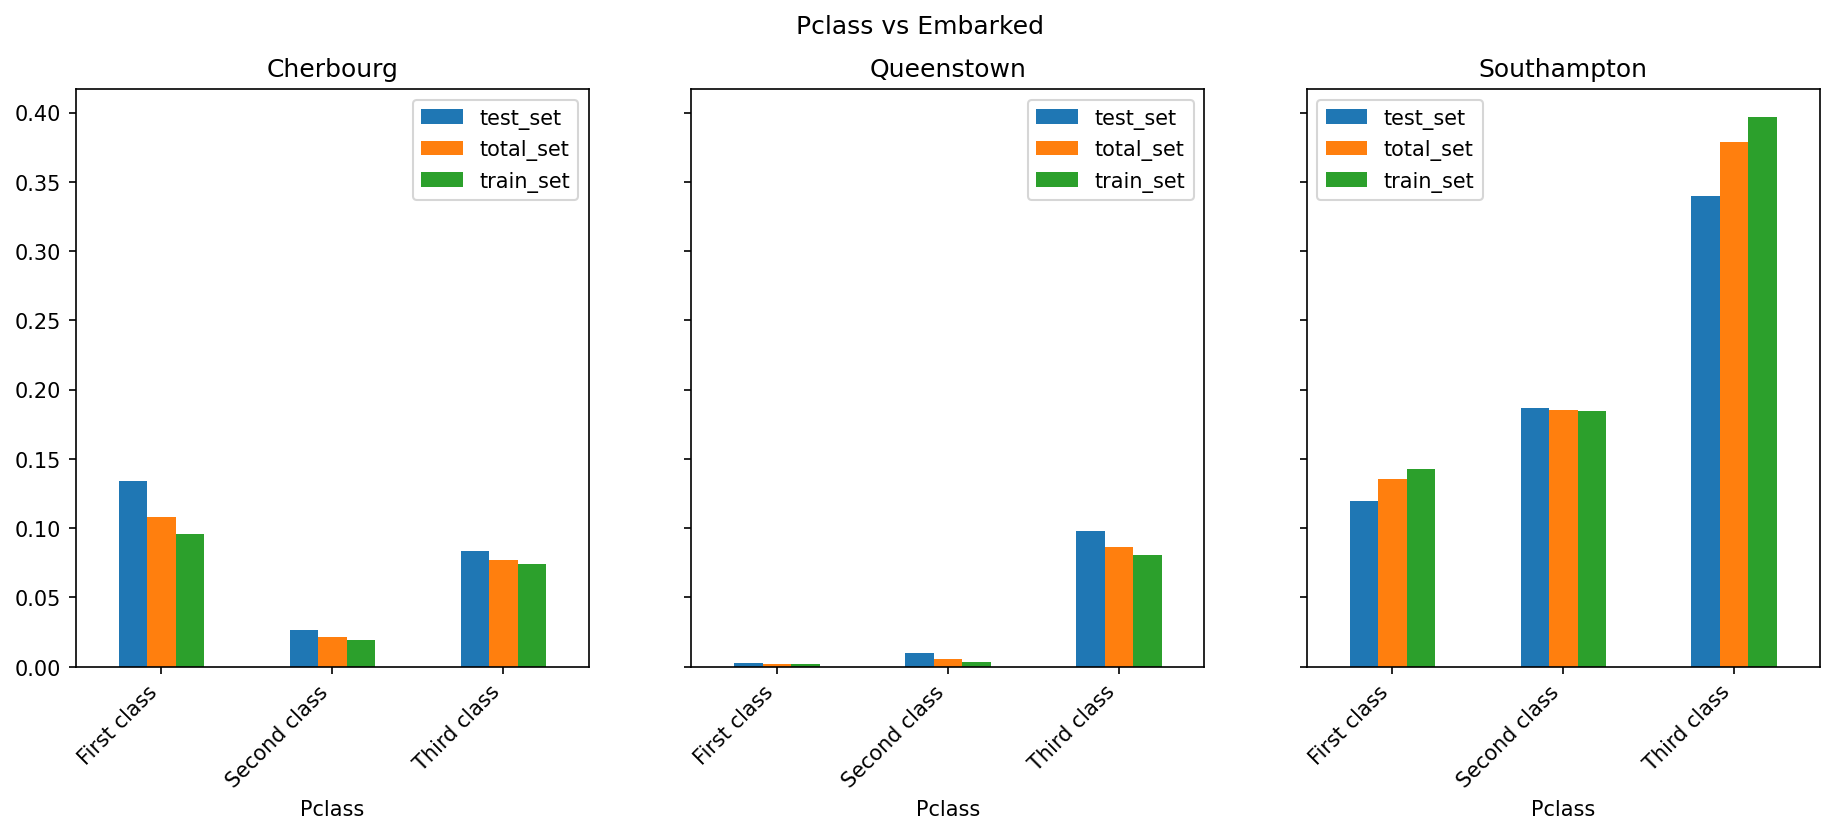

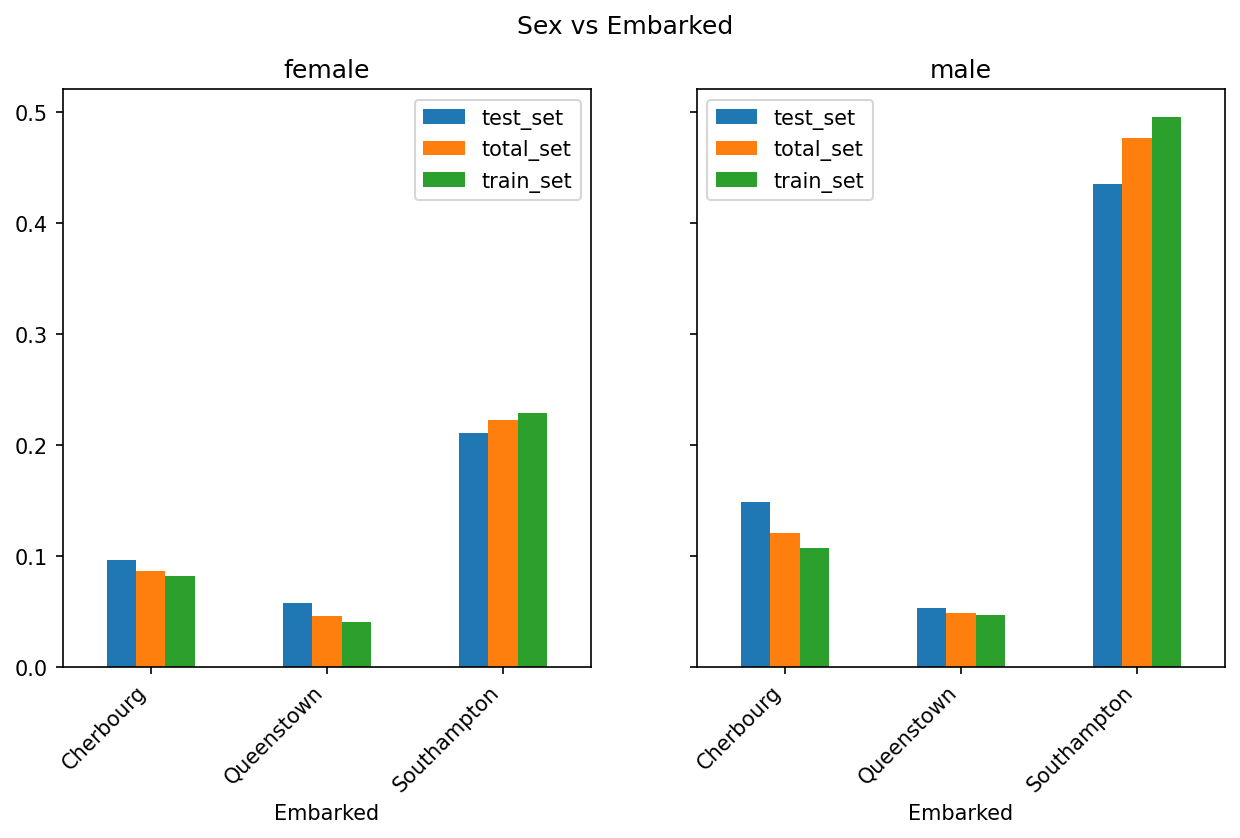

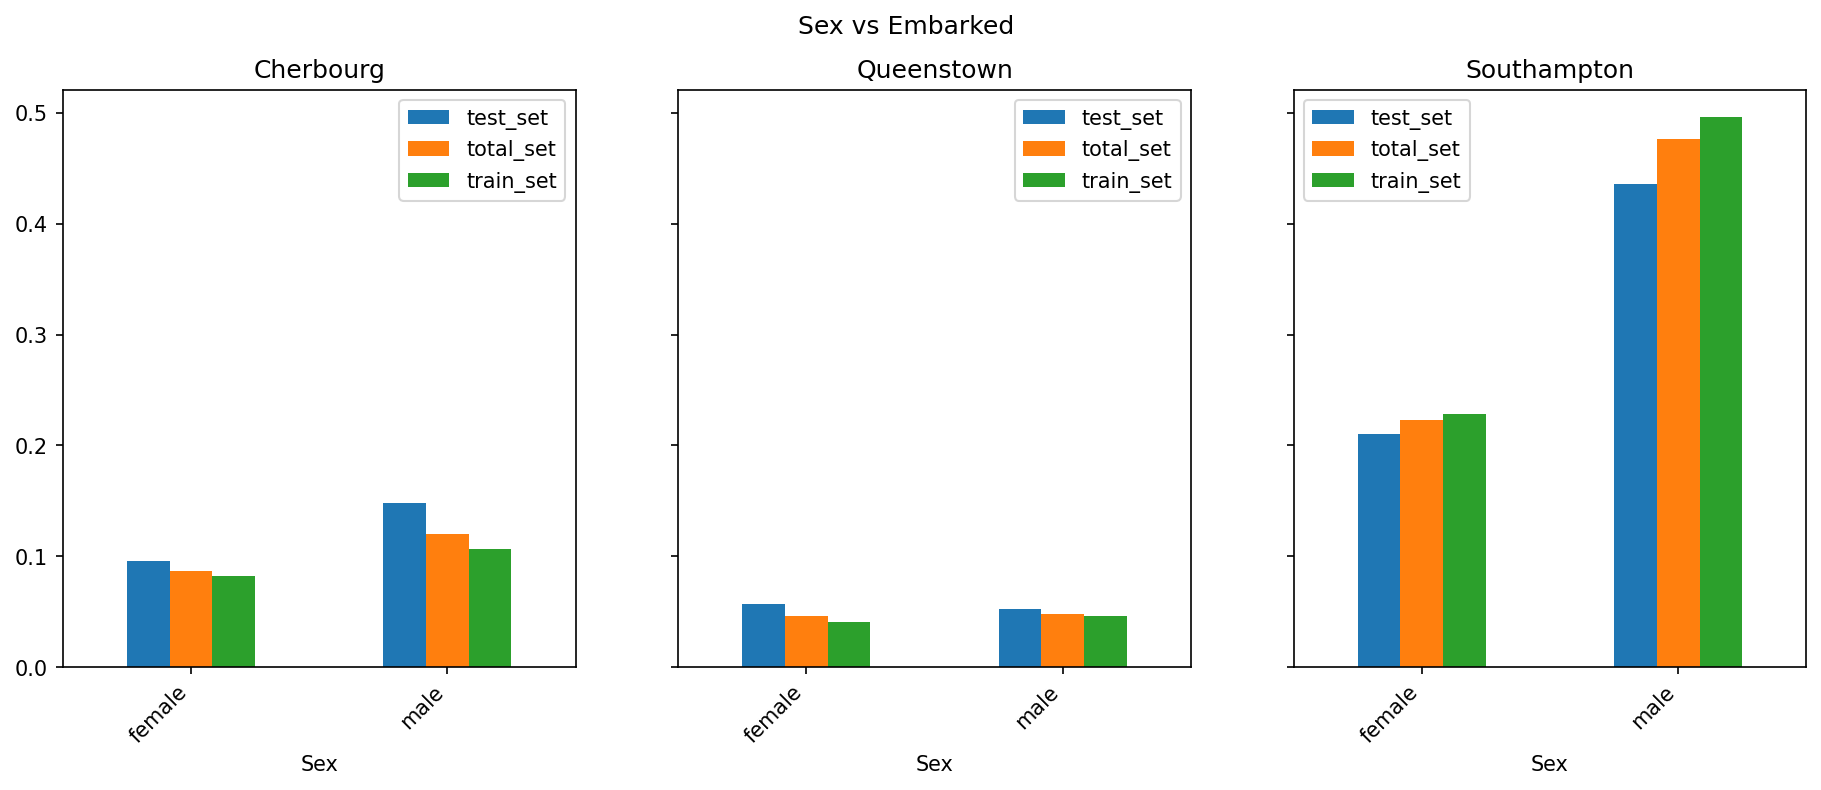

In [85]:
cutoff = 7

# Counts number of unique values in each column to filter with a cut off 
nuniques = total_df.apply(lambda x: x.nunique())
small_catergories = nuniques[nuniques < cutoff].keys()

# Make all combinations to plot against each other
small_catergories_permutations = combinations(small_catergories, 2)
for permutation in small_catergories_permutations:
    permutation = list(permutation)
    survived_percent = total_df.groupby(level=0)[permutation].value_counts(normalize=True)
    unstacked_df = survived_percent.unstack(level=0)
    for i in range(2):
        df_dict = {k: v.droplevel(permutation[i]) for k, v in unstacked_df.groupby(permutation[i])}
        fig, axes = plt.subplots(1, len(df_dict), figsize = (5*len(df_dict), 5), sharex=True, sharey=True)
        fig.suptitle(f'{" vs ".join(permutation)}')
        for ax, (group_value, df) in zip(axes.tolist(), df_dict.items()):
            df.plot(kind = 'bar', ax = ax)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = 'right')
            ax.set_title(f'{group_value}')
            
            

# Numerical values (Age, Sibsp, Parch, Fare)

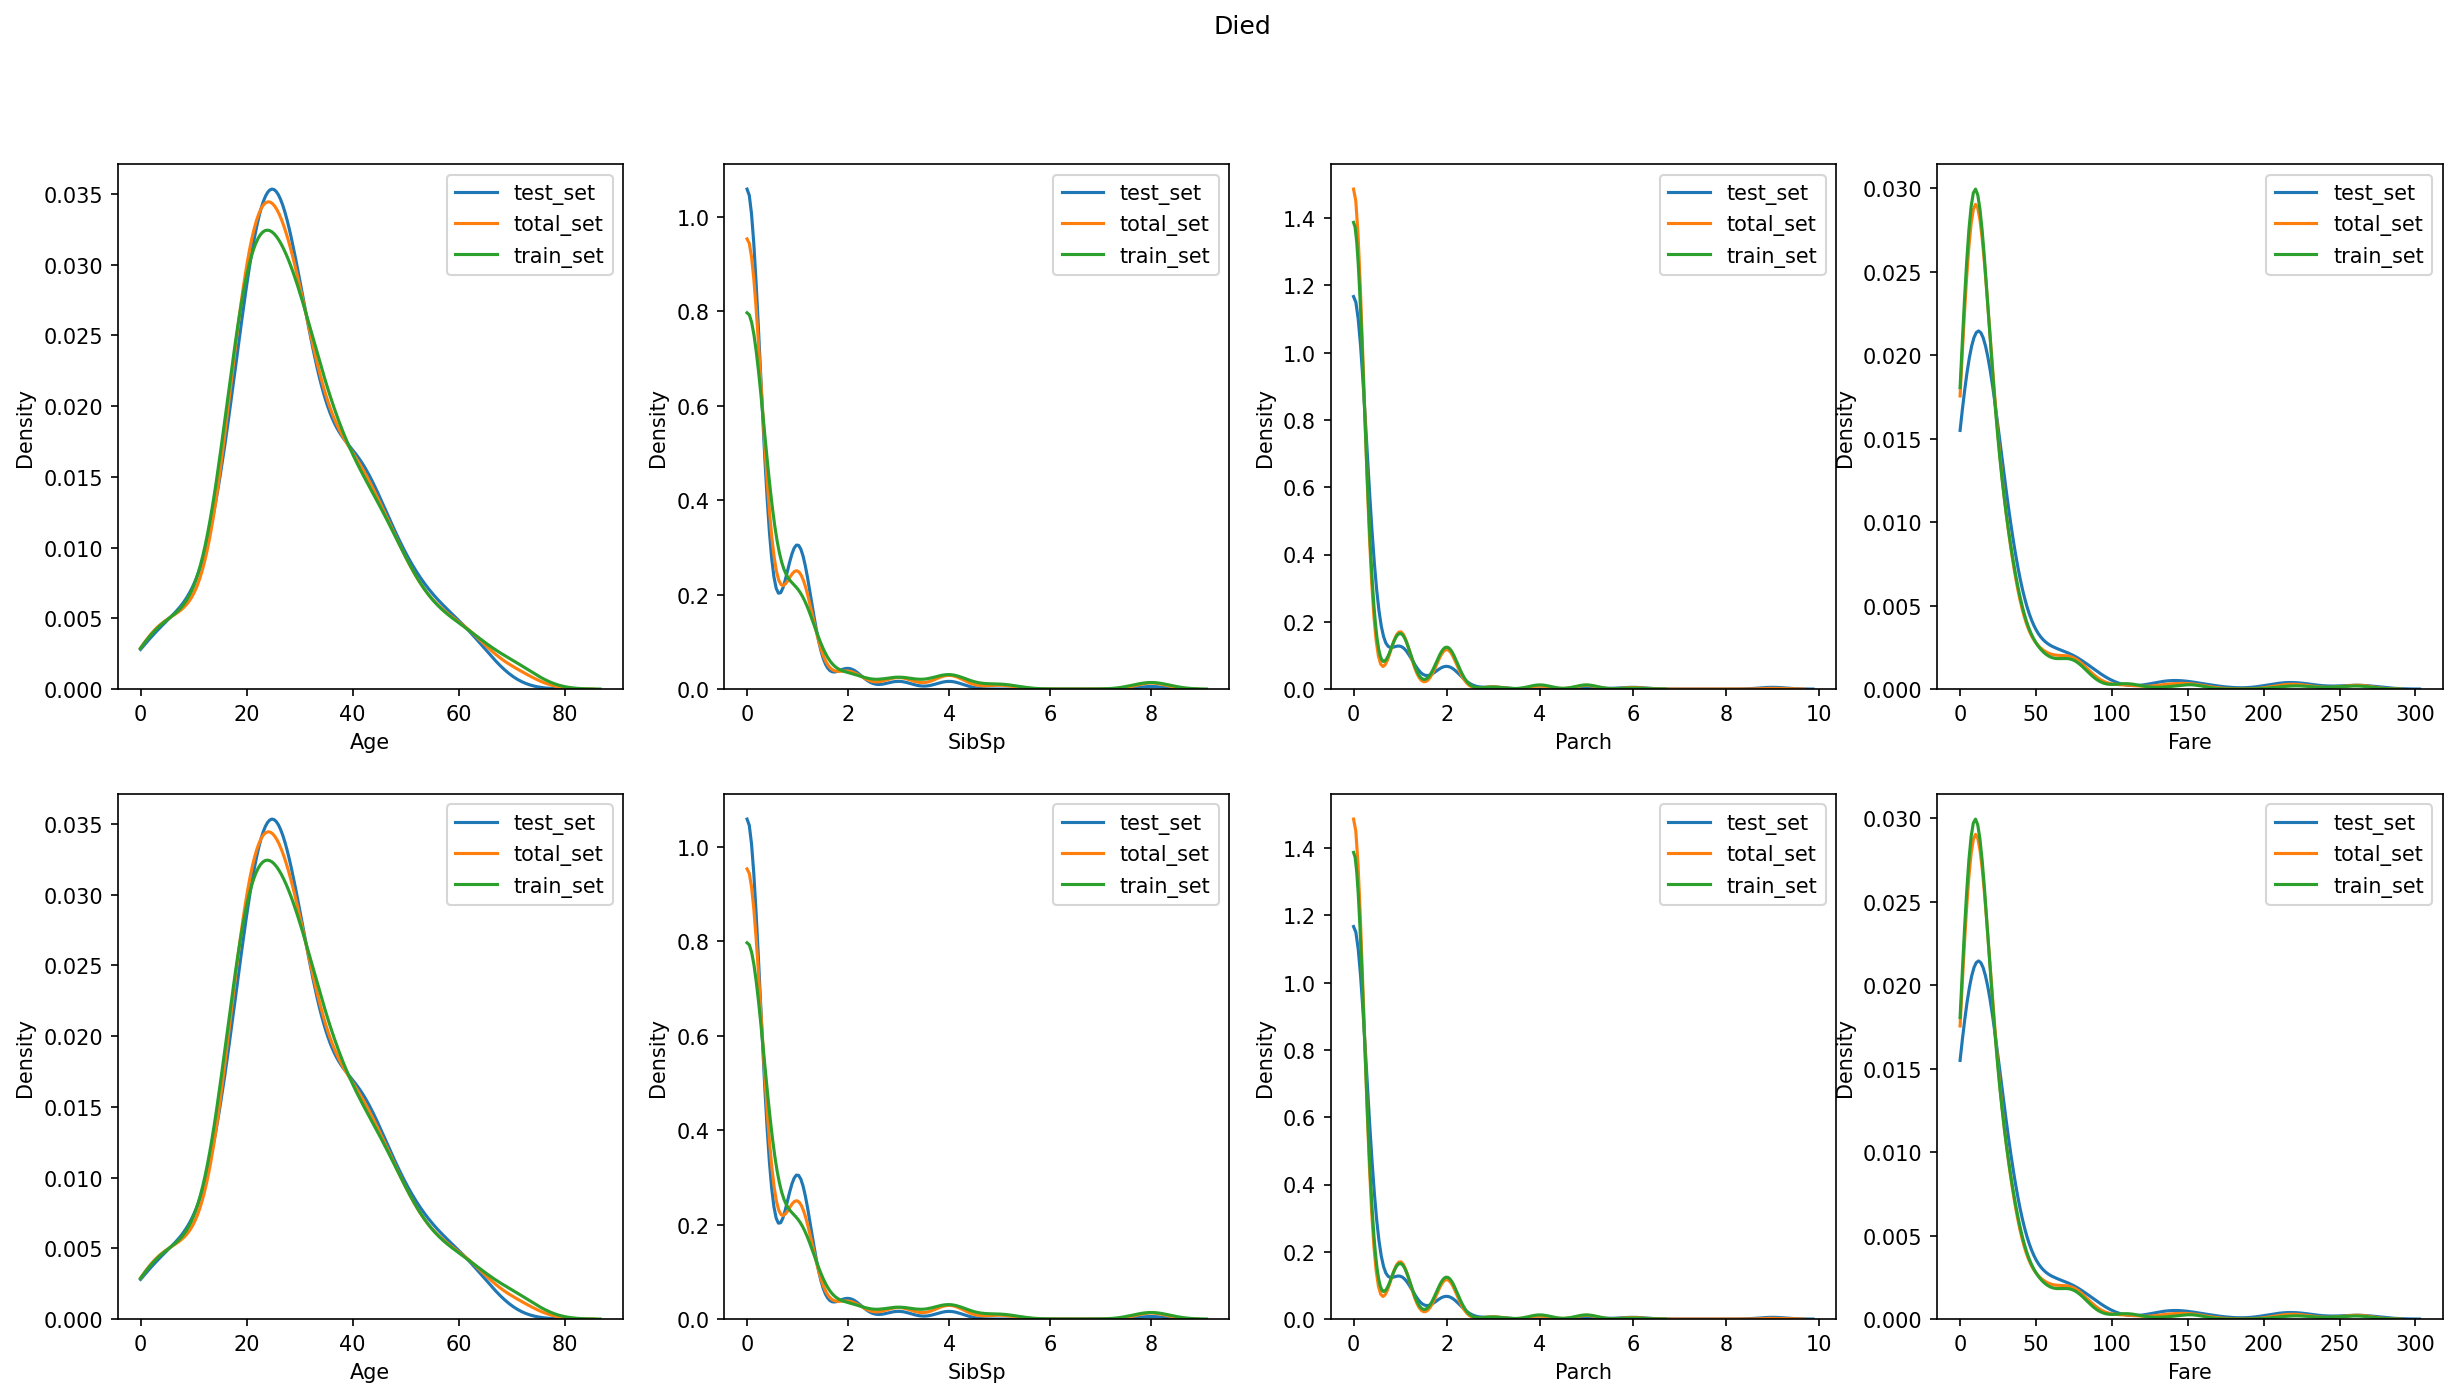

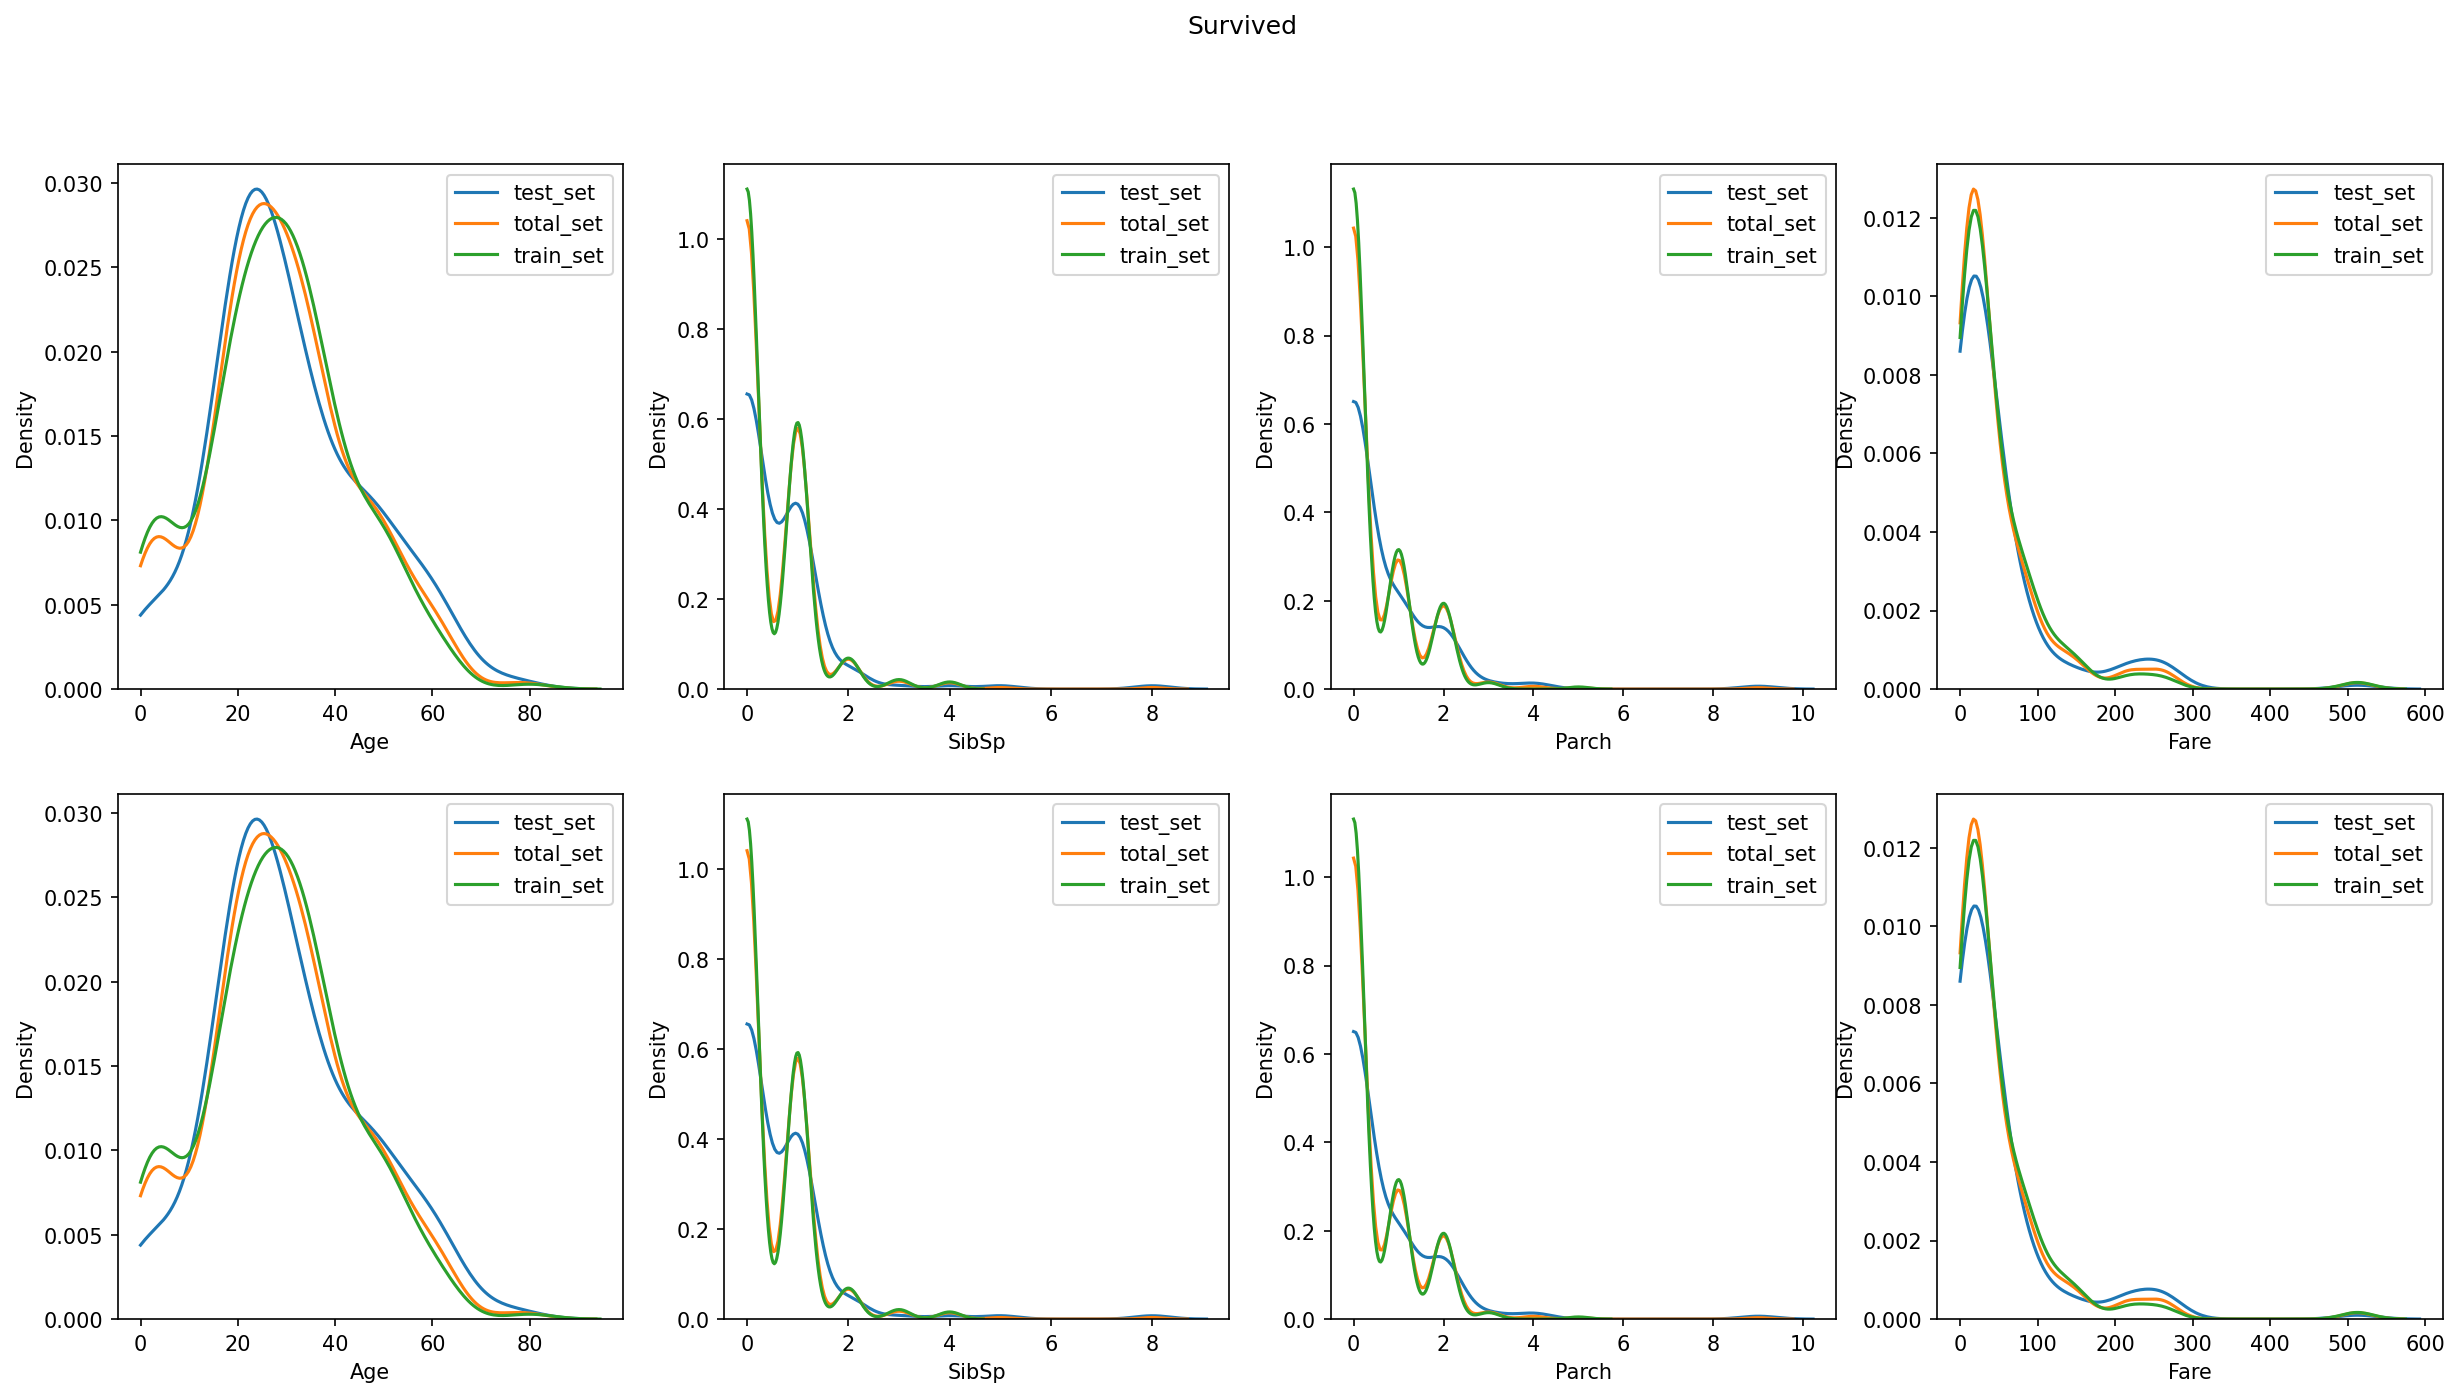

In [90]:
numerical_df = total_df.select_dtypes(include=['float', 'int']).drop(labels=['PassengerId'], axis = 1)
numerical_cols = numerical_df.columns

numerical_df['Survived'] = total_df['Survived']

survival_dict = {k: v.drop(labels=['Survived'], axis = 1) for k, v in numerical_df.groupby('Survived')}
for survival_state, df in survival_dict.items():
    
    fig, axes = plt.subplots(len(survival_dict), len(numerical_cols), figsize= (5 * len(numerical_cols), 5*len(survival_dict)))
    fig.suptitle(survival_state)
    groups = df.groupby(level=0)
    for ax_row in axes:
        for name, group in groups:
            group = group.droplevel(0)
            for ax, col in zip(ax_row, numerical_cols):
                series = group[col]
                sns.kdeplot(series, ax=ax, label = name, clip = [0, None])
        [ax.legend() for ax in ax_row]

            

In [219]:
def func(row):
    if not type(row) is list:
        return row
    else:
        cabins = [[x[0], int(x[1:])] for x in row if x[0].isalpha() and x[1:].isnumeric()]
        cabin_letter = list(set([cabin[0] for cabin in cabins]))
        try:
            cabin_mean = sum([cabin[1] for cabin in cabins]) / len(cabins)
            return f'{cabin_letter[0]},{cabin_mean}'
        
        except:
            return 'N' 

In [220]:
indiviual_cabins = total_df['Cabin'].str.split(' ')
modified_cabins = indiviual_cabins.apply(func).fillna(False)

    

'N'